In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
#from mpl_toolkits.axes_grid.inset_locator import (inset_axes, InsetPosition,
#                                                  mark_inset)
import matplotlib.cm as cmx
import matplotlib as mpl
import glob,os 
import pandas as pd
from sklearn.preprocessing import normalize, MinMaxScaler
from sklearn.metrics import accuracy_score
import matplotlib
%matplotlib inline

mpl.rc('lines', linewidth=2)
mpl.rc('axes', labelsize=16, titlesize=16)
mpl.rc('figure', titlesize=20)
mpl.rc('font', size=14)  # global font size
mpl.rc('legend', fontsize=14, fancybox=True)
mpl.rc('xtick.major', size=6)
mpl.rc('xtick.minor', size=4)
mpl.rcParams['font.size'] = 14.0

      
        
def tsne_plot(x_pred_encoded, y_train, plot_name, clabel="Temperature"):
    Dmax = y_train;
    [n,s] = np.histogram(Dmax, 11);
    d = np.digitize(Dmax, s);
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    #set_tick_font_size(ax, 16)
    ax.tick_params(axis='both', length=0)
     # remove labels under x-axis
    ax.set_xticklabels([])

    # remove labels left of y-axis
    ax.set_yticklabels([])   
    
    ax.set_title("Domain Classification", fontsize=24)
    #ax.yaxis.tick_right()
    #ax.yaxis.set_label_position("right")
    
    cmi = plt.get_cmap('jet');
    cNorm = mpl.colors.Normalize(vmin=min(Dmax), vmax=max(Dmax));
    scalarMap = mpl.cm.ScalarMappable(norm=cNorm, cmap=cmi);

    x = x_pred_encoded[:,0]
    y = x_pred_encoded[:,1]

    ax.scatter(x, y, c=scalarMap.to_rgba(Dmax), marker="o", s=1, alpha=0.5)
    #ax.set_xlabel("$t_1$", fontsize=18)
    #ax.set_ylabel("$t_2$", fontsize=18)
    scalarMap.set_array(Dmax);
    cbar = plt.colorbar(scalarMap, location='bottom', pad=0.02);
    cbar.set_ticks(list(labels.values()))
    cbar.set_ticklabels(list(labels.keys()))
    cbar.ax.tick_params(labelsize=24) 
    
   # ax.text(-25,65, "A", fontsize=20)
   # ax.text(60,-40, "B", fontsize=20)
    
    #ax.plot([-94,70], [-58,35])    
    #ax.text(-98,-70, "A")
    #ax.text(-45,-41, "B")
    #ax.text(0,-15, "C")
    #ax.text(70,25, "D")
    
    
    plt.savefig(plot_name, format='png',dpi=200, bbox_inches='tight');
    plt.show()
    plt.clf();

def filter_file(file_path):
    # Define the strings to filter out
    strings_to_remove = ["NCCL INFO", "RCCL version"]

    # Read the file and filter out lines
    with open(file_path, 'r') as file:
        lines = file.readlines()
    
    filtered_lines = [line for line in lines if not any(s in line for s in strings_to_remove)]

    # Write filtered lines back to the file
    with open(f"{file_path}.clean", 'w') as file:
        file.writelines(filtered_lines)
    return f"{file_path}.clean"

def read_commlog(sys="Frontier", op="all_reduce", n=1):
    comm = "nccl" if sys == "summit" else "rccl"
    fname = "data/{}/n{}/log.{}.n{}.*".format(comm, n, op, n)
    fname = glob.glob(fname)[0]
    fname = filter_file(fname)
    print(fname)
    
    header = ["size", "count", "type", "redop", "root", "out-time", "out-algbw", "out-busbw",
                   "out-error", "in-time", "in-algbw", "in-busbw", "in-error"]
    raw = pd.read_csv(fname, delim_whitespace=True, header=None, comment="#", names=header)
    '''
    if op == "all_reduce":
        raw.columns = [i for i in header if i != "root"]
    elif op == "all_gather":
        raw.columns = [i for i in header if i != "redop" and i != "root"]
    elif op == "alltoall":
        raw.columns = [i for i in header if i != "redop" and i != "root"]
    elif op == "reduce_scatter":
        raw.columns = [i for i in header if i != "root"]
    '''
    return raw 

print(read_commlog(op="reduce_scatter"))
def read_flops(mlp=4, a=8, d=48):
    folders = "data/mlp{}/a{}/d{}-h*".format(mlp, a, d)
    hmap = {}
    for folder in glob.glob(folders): 
        h = int(folder.split('-')[1][1:])
        log = glob.glob(f"{folder}/climax_sqg*")[0]
        with open(log, 'r') as file:
            for line in file:
                if "Training performance:" in line:
                    flops = float(line.strip().split(':')[1][:-6])
                    break 
        hmap[(mlp,a,h)] = flops 
    return hmap

print(read_flops())

data/rccl/n1\log.reduce_scatter.n1.1668649.clean
          size      count   type redop  root  out-time  out-algbw  out-busbw  \
0      1048576      32768  float   sum    -1     42.02      24.95      21.83   
1      2097152      65536  float   sum    -1     50.01      41.94      36.69   
2      4194304     131072  float   sum    -1     64.05      65.49      57.30   
3      8388608     262144  float   sum    -1     98.23      85.40      74.72   
4     16777216     524288  float   sum    -1    152.00     110.36      96.57   
5     33554432    1048576  float   sum    -1    261.00     128.57     112.50   
6     67108864    2097152  float   sum    -1    482.80     139.01     121.63   
7    134217728    4194304  float   sum    -1    930.00     144.31     126.27   
8    268435456    8388608  float   sum    -1   1825.80     147.02     128.64   
9    536870912   16777216  float   sum    -1   3619.70     148.32     129.78   
10  1073741824   33554432  float   sum    -1   7181.40     149.52     1

In [15]:
from glob import glob
def read_stats(datadir='gpt13b-n1-offload', gpuid=0):
    fname = glob("{}/log.*".format(datadir))[0]
    print(fname)
    pwr, mem, util = {}, {}, {}

    df = pd.read_csv(fname, header=None)
    pwr = df.iloc[gpuid::8, 0].astype(float).reset_index(drop=True).to_dict()
    mem = df.iloc[gpuid::8, 3].astype(float).reset_index(drop=True).to_dict()
    util = df.iloc[gpuid::8, 1].astype(float).reset_index(drop=True).to_dict()
                
    return pwr, mem, util



def measure(pwr, tmin=1000, tmax=1500):
    ps=[]
    for t,p in pwr.items():
        if t >=tmin and t <=tmax:
            ps.append(p)
    ps = np.array(ps, dtype=float)
    return ps.mean(), ps.std()


print(read_stats("../../energy"))

../../energy\log.gpu.n64.1818835
({0: 89.0, 1: 89.0, 2: 91.0, 3: 92.0, 4: 92.0, 5: 92.0, 6: 86.0, 7: 86.0, 8: 90.0, 9: 91.0, 10: 92.0, 11: 92.0, 12: 92.0, 13: 92.0, 14: 90.0, 15: 91.0, 16: 90.0, 17: 89.0, 18: 88.0, 19: 88.0, 20: 90.0, 21: 89.0, 22: 89.0, 23: 89.0, 24: 89.0, 25: 89.0, 26: 89.0, 27: 90.0, 28: 90.0, 29: 90.0, 30: 90.0, 31: 89.0, 32: 89.0, 33: 87.0, 34: 88.0, 35: 87.0, 36: 89.0, 37: 86.0, 38: 87.0, 39: 87.0, 40: 89.0, 41: 89.0, 42: 88.0, 43: 89.0, 44: 88.0, 45: 89.0, 46: 89.0, 47: 90.0, 48: 89.0, 49: 90.0, 50: 90.0, 51: 90.0, 52: 89.0, 53: 89.0, 54: 88.0, 55: 89.0, 56: 89.0, 57: 90.0, 58: 90.0, 59: 88.0, 60: 88.0, 61: 88.0, 62: 88.0, 63: 88.0, 64: 88.0, 65: 88.0, 66: 87.0, 67: 88.0, 68: 88.0, 69: 88.0, 70: 88.0, 71: 87.0, 72: 88.0, 73: 89.0, 74: 89.0, 75: 88.0, 76: 88.0, 77: 88.0, 78: 89.0, 79: 88.0, 80: 88.0, 81: 87.0, 82: 87.0, 83: 87.0, 84: 88.0, 85: 89.0, 86: 88.0, 87: 88.0, 88: 88.0, 89: 88.0, 90: 88.0, 91: 88.0, 92: 88.0, 93: 88.0, 94: 88.0, 95: 88.0, 96: 87.0, 97: 8

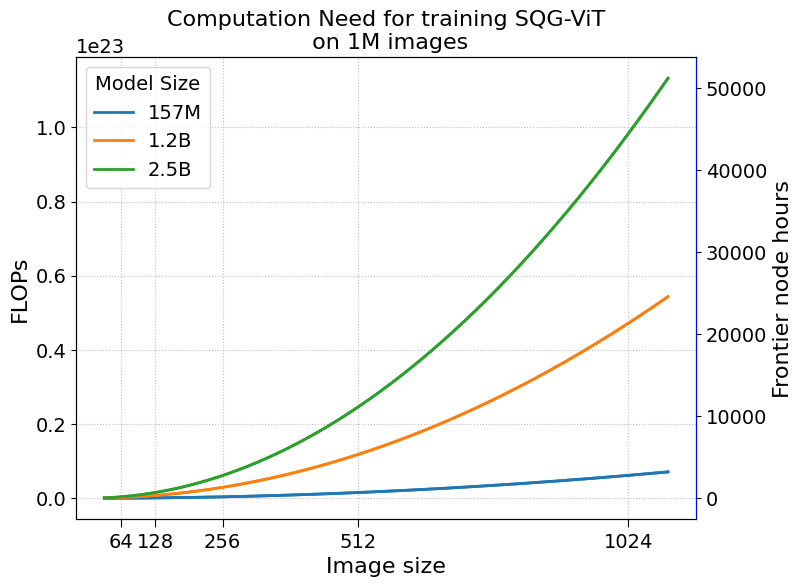

In [57]:


font = {'family': 'sans-serif',
        'color':  'black',
        'weight': 'normal',
        'size': 16,
        }
fig, ax = plt.subplots(figsize=(8,6))

models = [157*10**6, 1.2*10**9, 2.5*10**9]
labels = ['157M', '1.2B', '2.5B']


flops_frontier_node = 384 *4 *10**12 

def flops_opt(x, y):
    #output = 120*np.power(x,2)*np.power(10.,24) #*10**24
    output = 6.*(x/4)**2*10**6*100*y 
    return output 

ax2 = ax.twinx()
ax2.spines['right'].set_color('blue')
df = pd.DataFrame({'x':np.arange(32, 1100)})
for m,l in zip(models, labels):

    df['y'] = flops_opt(df['x'], m)
    ax.plot(df['x'], df['y'], label=l)

    ax2.plot(df['x'], df['y']/(flops_frontier_node*0.4)/3600)
#ax2.set_ylim((np.power(10., 0), np.power(10.,3)))
#ax2.set_yscale('log')
ax2.set_ylabel('Frontier node hours', fontdict=font)


ax.legend(fontsize=14, title='Model Size')
#set_tick_font_size(ax, 14)
ax.grid(color='silver', linestyle='dotted',)
ax.set_xticks((64,128,256,512,1024))
ax.set_xlabel('Image size', fontdict=font)
ax.set_ylabel('FLOPs', fontdict=font)
ax.set_title('Computation Need for training SQG-ViT\n on 1M images', fontdict=font)

fig.savefig('compute-need.png', dpi=300, bbox_inches='tight' )



In [25]:
nodes = [2,4,8,16,32,64,128]
allreduce_64M = [read_commlog(op="all_reduce", n=n)['out-algbw'][6]  for n in nodes]
print(allreduce_64M)
allgather_64M = [read_commlog(op="all_gather", n=n)['out-algbw'][6]  for n in nodes]
print(allgather_64M)
reducescatter_64M = [read_commlog(op="reduce_scatter", n=n)['out-algbw'][6]  for n in nodes]
print(reducescatter_64M)

allreduce_256M = [read_commlog(op="all_reduce", n=n)['out-algbw'][8]  for n in nodes]
print(allreduce_64M)
allgather_256M = [read_commlog(op="all_gather", n=n)['out-algbw'][8]  for n in nodes]
print(allgather_64M)
reducescatter_256M = [read_commlog(op="reduce_scatter", n=n)['out-algbw'][8]  for n in nodes]
print(reducescatter_64M)



data/rccl/n2\log.all_reduce.n2.1668900.clean
data/rccl/n4\log.all_reduce.n4.1668911.clean
data/rccl/n8\log.all_reduce.n8.1668970.clean
data/rccl/n16\log.all_reduce.n16.1669121.clean
data/rccl/n32\log.all_reduce.n32.1669137.clean
data/rccl/n64\log.all_reduce.n64.1669232.clean
data/rccl/n128\log.all_reduce.n128.1669313.clean
[27.29, 14.98, 9.99, 9.36, 8.29, 7.9, 7.79]
data/rccl/n2\log.all_gather.n2.1668900.clean
data/rccl/n4\log.all_gather.n4.1668911.clean
data/rccl/n8\log.all_gather.n8.1668970.clean
data/rccl/n16\log.all_gather.n16.1669121.clean
data/rccl/n32\log.all_gather.n32.1669137.clean
data/rccl/n64\log.all_gather.n64.1669232.clean
data/rccl/n128\log.all_gather.n128.1669313.clean
[35.04, 28.08, 14.76, 8.66, 4.28, 2.32, 1.18]
data/rccl/n2\log.reduce_scatter.n2.1668900.clean
data/rccl/n4\log.reduce_scatter.n4.1668911.clean
data/rccl/n8\log.reduce_scatter.n8.1668970.clean
data/rccl/n16\log.reduce_scatter.n16.1669121.clean
data/rccl/n32\log.reduce_scatter.n32.1669137.clean
data/rccl/n

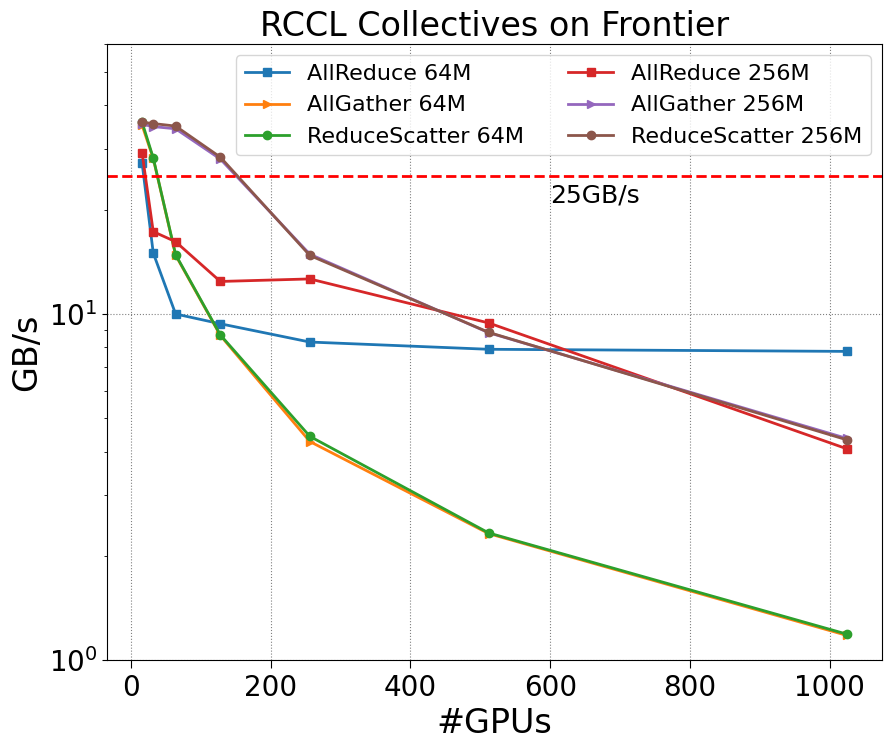

In [32]:
font = {'family': 'sans-serif',
        'color':  'black',
        'weight': 'normal',
        'size': 24,
        }

fig, ax = plt.subplots(figsize=(10, 8))

#ax.set_ylim((400,600))
#set_tick_font_size(ax, 22)
ax.tick_params(axis='y', labelsize=20)
ax.tick_params(axis='x', labelsize=20)

ax.plot(np.array(nodes)*8, np.array(allreduce_64M), marker='s', label='AllReduce 64M')
ax.plot(np.array(nodes)*8, np.array(allgather_64M), marker='>', label='AllGather 64M')
ax.plot(np.array(nodes)*8, np.array(reducescatter_64M), marker='o', label='ReduceScatter 64M')


ax.plot(np.array(nodes)*8, np.array(allreduce_256M), marker='s', label='AllReduce 256M')
ax.plot(np.array(nodes)*8, np.array(allgather_256M), marker='>', label='AllGather 256M')
ax.plot(np.array(nodes)*8, np.array(reducescatter_256M), marker='o', label='ReduceScatter 256M')

#ax.plot(np.array(nodes)*8, np.array(ideal_flash)/1000, linestyle='dotted', color='k', label='ideal')

ax.grid(color='gray', linestyle='dotted')
ax.set_title("RCCL Collectives on Frontier",fontdict=font)
ax.set_ylabel('GB/s', fontdict=font)
ax.set_xlabel('#GPUs', fontdict=font)
ax.set_yscale('log')
ax.axhline(y=25, color='r', linestyle='--')
ax.set_ylim((1,60))
#ax.set_yticks([0,5,10,15,20])
ax.text(600, 21, "25GB/s", fontsize=18)

ax.legend(fontsize=16, ncol=2)
plt.savefig('rccl.png', dpi=300, bbox_inches='tight')

data/rccl/n128\log.all_reduce.n128.1669313.clean
          size       count   type redop  root  out-time  out-algbw  out-busbw  \
4     16777216     4194304  float   sum    -1    4591.5       3.65       7.30   
5     33554432     8388608  float   sum    -1    7041.3       4.77       9.52   
6     67108864    16777216  float   sum    -1    8618.7       7.79      15.56   
7    134217728    33554432  float   sum    -1   16362.0       8.20      16.39   
8    268435456    67108864  float   sum    -1   65870.0       4.08       8.14   
9    536870912   134217728  float   sum    -1   44752.0      12.00      23.97   
10  1073741824   268435456  float   sum    -1   67456.0      15.92      31.80   
11  2147483648   536870912  float   sum    -1  126819.0      16.93      33.83   
12  4294967296  1073741824  float   sum    -1  255367.0      16.82      33.60   

    out-error   in-time  in-algbw  in-busbw  in-error  
4           0    4535.6      3.70      7.39         0  
5           0    5701.2     

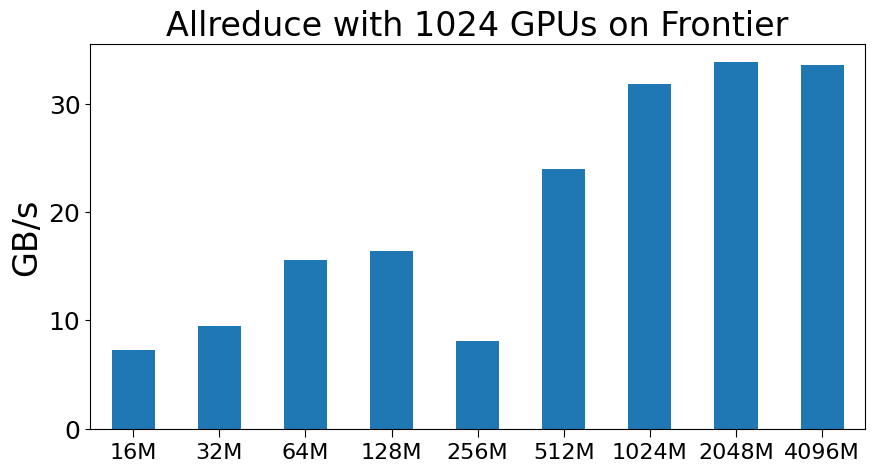

In [67]:
allreduce = read_commlog(op="all_reduce", n=128)[4::]
print(allreduce)

labels = ['16M','32M','64M','128M','256M','512M','1024M','2048M','4096M']
bw = {"Bandwidth": allreduce['out-busbw'].tolist(),
          "labels": labels 
         }

df = pd.DataFrame(bw, index=labels)


ax = df.plot(kind='bar', figsize=(10,5))
ax.set_xticklabels(df.index, rotation=0)
ax.set_ylabel("GB/s", fontdict=font)
ax.tick_params(axis='y', labelsize=18)
ax.tick_params(axis='x', labelsize=16)

ax.set_title("Allreduce with 1024 GPUs on Frontier", fontdict=font)
#ax.legend(loc='best', fontsize=22)
ax.get_legend().remove()
plt.savefig('allreduce.png', dpi=300, bbox_inches='tight')

50.15210080714057
[349.06540453283895, 653.1028868356342, 1275.4488541842122, 2564.9512649281414, 5155.160797704504, 10131.665492654894, 19685.71782312988, 37847.040906793416]
0.8588708016320231


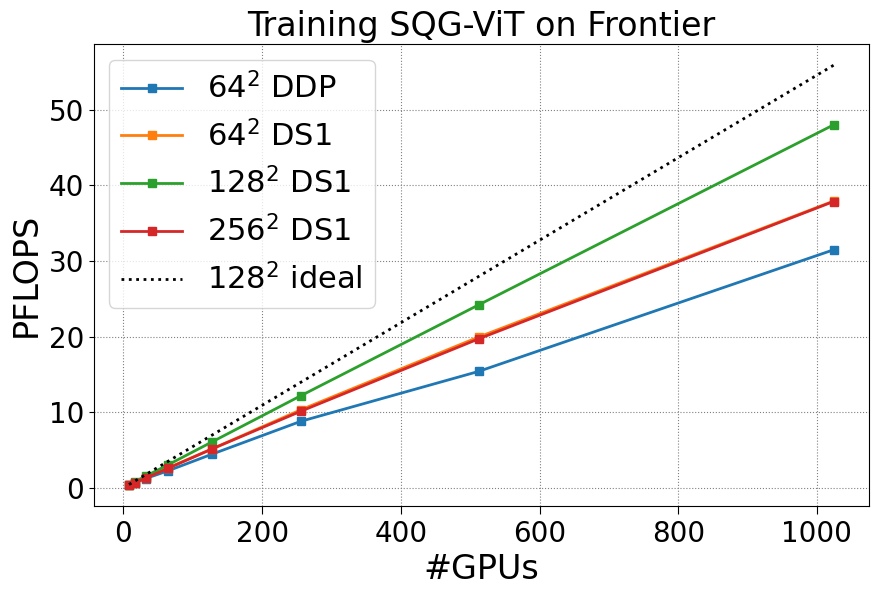

In [22]:

import re
from glob import glob 

def read_perf(datadir, n):
    file = glob("{}/n{}/sqg_log.*".format(datadir,n))[0]
    with open(file, "r") as f:
        data = f.read()
    pattern = r'(\d+\.\d+)TFLOPS'

    tflops = re.findall(pattern, data)
    mean_tflops = sum(map(float, tflops)) / len(tflops)
    return mean_tflops

print(read_perf('data/input/128', 2, ))



nodes = [1,2,4,8,16,32,64,128]
perf_64_ddp = [ read_perf('data/input/64/ddp', n)*8*n for n in nodes ]
perf_64_ds1 = [ read_perf('data/input/64/ds1', n)*8*n for n in nodes ]
perf_128 = [ read_perf('data/input/128', n)*8*n for n in nodes ]
perf_256 = [ read_perf('data/input/256', n)*8*n for n in nodes ]

print(perf_256)

ideal = [perf_128[0]*n/nodes[0]  for n in nodes]

print(perf_128[-1]/ideal[-1])


font = {'family': 'sans-serif',
        'color':  'black',
        'weight': 'normal',
        'size': 24,
        }

fig, ax = plt.subplots(figsize=(10, 6))

ax.tick_params(axis='y', labelsize=20)
ax.tick_params(axis='x', labelsize=20)

#ax.plot(np.array(nodes)*8, np.array(perf)/1000, marker='s', label='data')
ax.plot(np.array(nodes)*8, np.array(perf_64_ddp)/1e3, marker='s', label='64$^2$ DDP')
ax.plot(np.array(nodes)*8, np.array(perf_64_ds1)/1e3, marker='s', label='64$^2$ DS1')
ax.plot(np.array(nodes)*8, np.array(perf_128)/1e3, marker='s', label='128$^2$ DS1')
ax.plot(np.array(nodes)*8, np.array(perf_256)/1e3, marker='s', label='256$^2$ DS1')

ax.plot(np.array(nodes)*8, np.array(ideal)/1000, linestyle='dotted', color='k', label='128$^2$ ideal')

ax.grid(color='gray', linestyle='dotted')
ax.set_title("Training SQG-ViT on Frontier",fontdict=font)
ax.set_ylabel('PFLOPS', fontdict=font)
ax.set_xlabel('#GPUs', fontdict=font)
#ax.set_ylim((0,20))
#ax.set_yticks([0,5,10,15,20])

ax.legend(fontsize=22)
plt.savefig('scale1.png', dpi=300, bbox_inches='tight')


40.81893042722714
0.8470619065789057


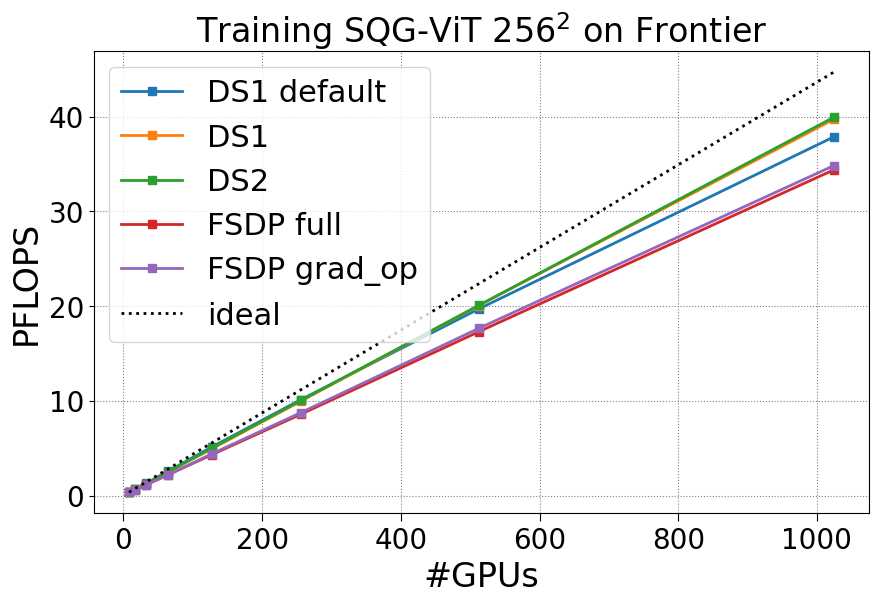

In [21]:

import re
from glob import glob 

def read_perf(datadir, n):
    file = glob("{}/n{}/*sqg*".format(datadir,n))[0]
    with open(file, "r") as f:
        data = f.read()
    pattern = r'(\d+\.\d+)TFLOPS'

    tflops = re.findall(pattern, data)
    mean_tflops = sum(map(float, tflops)) / len(tflops)
    return mean_tflops

print(read_perf('data/scaling/ds1-baseline', 2, ))



nodes = [2,4,8,16,32,64,128]
perf_ds1_baseline = [ read_perf('data/scaling/ds1-baseline', n)*8*n for n in nodes ]
perf_ds1 = [ read_perf('data/scaling/ds1', n, )*8*n for n in nodes ]
perf_ds2 = [ read_perf('data/scaling/ds2', n, )*8*n for n in nodes ]

single_node = [read_perf('data/scaling/ds1-baseline', 1)*8*1]
perf_ds1_baseline = single_node + perf_ds1_baseline
perf_ds1 = single_node + perf_ds1
perf_ds2 = single_node + perf_ds2

perf_fsdp_full = [ read_perf('data/scaling/fsdp/full', n, )*8*n for n in nodes ]
perf_fsdp_gradop = [ read_perf('data/scaling/fsdp/grad-op', n, )*8*n for n in nodes ]

perf_fsdp_full = single_node + perf_fsdp_full
perf_fsdp_gradop = single_node + perf_fsdp_gradop

nodes = [1,2,4,8,16,32,64,128]
ideal = [perf_ds1_baseline[0]*n/nodes[0]  for n in nodes]

print(perf_ds1_baseline[-1]/ideal[-1])


font = {'family': 'sans-serif',
        'color':  'black',
        'weight': 'normal',
        'size': 24,
        }

fig, ax = plt.subplots(figsize=(10, 6))

ax.tick_params(axis='y', labelsize=20)
ax.tick_params(axis='x', labelsize=20)
#ax.plot(np.array(nodes)*8, np.array(perf)/1000, marker='s', label='data')
ax.plot(np.array(nodes)*8, np.array(perf_ds1_baseline)/1e3, marker='s', label='DS1 default')
ax.plot(np.array(nodes)*8, np.array(perf_ds1)/1e3, marker='s', label='DS1')
ax.plot(np.array(nodes)*8, np.array(perf_ds2)/1e3, marker='s', label='DS2')
ax.plot(np.array(nodes)*8, np.array(perf_fsdp_full)/1e3, marker='s', label='FSDP full')
ax.plot(np.array(nodes)*8, np.array(perf_fsdp_gradop)/1e3, marker='s', label='FSDP grad_op')

ax.plot(np.array(nodes)*8, np.array(ideal)/1000, linestyle='dotted', color='k', label='ideal')

ax.grid(color='gray', linestyle='dotted')
ax.set_title("Training SQG-ViT 256$^2$ on Frontier",fontdict=font)
ax.set_ylabel('PFLOPS', fontdict=font)
ax.set_xlabel('#GPUs', fontdict=font)
#ax.set_ylim((0,20))
#ax.set_yticks([0,5,10,15,20])

ax.legend(fontsize=22)
plt.savefig('scale2.png', dpi=300, bbox_inches='tight')


{(4, 8, 1664): 33.232406393340455, (4, 8, 1728): 34.23910513579665, (4, 8, 1792): 36.92070829461607, (4, 8, 1856): 37.63958466867994, (4, 8, 1920): 38.60287874966184, (4, 8, 1984): 39.65229522647217, (4, 8, 2048): 43.5722354345612, (4, 8, 2112): 40.398181097983894, (4, 8, 2176): 41.542309597360536, (4, 8, 2240): 42.03067239132125, (4, 16, 1664): 27.6178821638181, (4, 16, 1728): 28.57916328376247, (4, 16, 1792): 30.63491415906911, (4, 16, 1856): 31.327775298220306, (4, 16, 1920): 32.37183708021979, (4, 16, 1984): 33.774667698976806, (4, 16, 2048): 38.039319097235975, (4, 16, 2112): 33.544836584391675, (4, 16, 2176): 34.33650273017426, (4, 16, 2240): 26.850032749200775}


Text(0.5, 1.0, 'Heatmap')

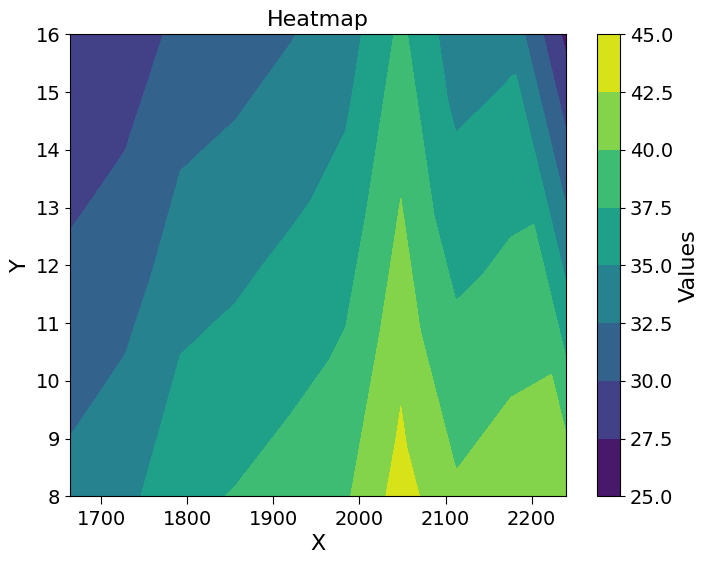

In [15]:
hmap = read_flops(mlp=4, a=8, d=48)
hmap.update(read_flops(mlp=4, a=16, d=48))
print(hmap)


x = np.array([k[2] for k in hmap.keys()]) # third value in each tuple
y = np.array([k[1] for k in hmap.keys()]) # second value in each tuple
z = np.array(list(hmap.values()))

# Create heatmap
plt.figure(figsize=(8, 6))
plt.tricontourf(x, y, z, cmap='viridis')
plt.colorbar(label='Values')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Heatmap')
    



{(4, 8, 1664): 33.232406393340455, (4, 8, 1728): 34.23910513579665, (4, 8, 1792): 36.92070829461607, (4, 8, 1856): 37.63958466867994, (4, 8, 1920): 38.60287874966184, (4, 8, 1984): 39.65229522647217, (4, 8, 2048): 43.5722354345612, (4, 8, 2112): 40.398181097983894, (4, 8, 2176): 41.542309597360536, (4, 8, 2240): 42.03067239132125, (4, 16, 1664): 27.6178821638181, (4, 16, 1728): 28.57916328376247, (4, 16, 1792): 30.63491415906911, (4, 16, 1856): 31.327775298220306, (4, 16, 1920): 32.37183708021979, (4, 16, 1984): 33.774667698976806, (4, 16, 2048): 38.039319097235975, (4, 16, 2112): 33.544836584391675, (4, 16, 2176): 34.33650273017426, (4, 16, 2240): 26.850032749200775}
{(8, 8, 1664): 40.168242649064545, (8, 8, 1728): 43.23755760233268, (8, 8, 1792): 46.04829324916236, (8, 8, 1856): 46.628141212623284, (8, 8, 1920): 48.20581346845421, (8, 8, 1984): 47.96658300117664, (8, 8, 2048): 51.809170368944834, (8, 8, 2112): 48.47654709105677, (8, 8, 2176): 42.32204977309928, (8, 8, 2240): 49.40567

C:\Users\yzn\AppData\Local\Temp\ipykernel_7176\2573638553.py:38: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


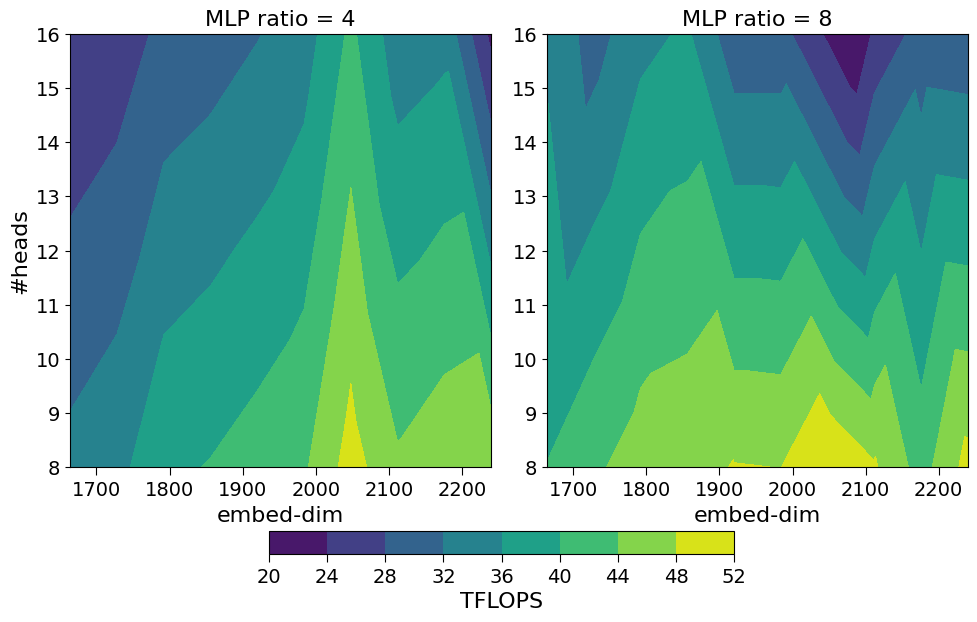

In [22]:
hmap1 = read_flops(mlp=4, a=8, d=48)
hmap1.update(read_flops(mlp=4, a=16, d=48))
print(hmap1)

hmap2 = read_flops(mlp=8, a=8, d=48)
hmap2.update(read_flops(mlp=8, a=16, d=48))
print(hmap2)

# Extract x, y, z values for heatmap 1
x1 = [key[2] for key in hmap1.keys()]
y1 = [key[1] for key in hmap1.keys()]
z1 = list(hmap1.values())

# Extract x, y, z values for heatmap 2
x2 = [key[2] for key in hmap2.keys()]
y2 = [key[1] for key in hmap2.keys()]
z2 = list(hmap2.values())

# Create shared colorbar
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# Plot heatmap 1
#heatmap1 = ax1.scatter(x1, y1, c=z1, cmap='viridis')
heatmap1 = ax1.tricontourf(x1, y1, z1, cmap='viridis')
ax1.set_title('MLP ratio = 4')
ax1.set_xlabel('embed-dim')
ax1.set_ylabel('#heads')

# Plot heatmap 2
#heatmap2 = ax2.scatter(x2, y2, c=z2, cmap='viridis')
heatmap2 = ax2.tricontourf(x2, y2, z2, cmap='viridis')
ax2.set_title('MLP ratio = 8')
ax2.set_xlabel('embed-dim')
# Add colorbar
cbar = fig.colorbar(heatmap2, ax=[ax1, ax2], orientation='horizontal', shrink=0.6, anchor=(0.5, -3.5))
cbar.set_label('TFLOPS')

plt.tight_layout()
plt.savefig('heatmap.png', dpi=300, bbox_inches='tight')

In [26]:
io_64 = pd.read_csv("data/profs/input-size/64/results.copy_stats.csv")
print(io_64)

com_64 = pd.read_csv("data/profs/input-size/64/results.stats.csv")
comm_64 = com_64[com_64['Name'].str.contains('nccl')]
com_64 = com_64[~com_64['Name'].str.contains('nccl|barrier')]

print(comm_64)

com_time = com_64['TotalDurationNs'].sum()
io_time = io_64['TotalDurationNs'].sum()
comm_time = comm_64['TotalDurationNs'].sum()

total_time = com_time + io_time + comm_time

perc_64 = np.array([com_time, comm_time, io_time])/total_time

print(perc_64)

print(com_time/10**6, io_time/10**6, comm_time/10**6)

                 Name  Calls  TotalDurationNs  AverageNs  Percentage
0    CopyDeviceToHost   1620        101763491      62816   45.588619
1  CopyDeviceToDevice  14353         94922981       6613   42.524166
2          FillBuffer   4484         16063607       3582    7.196271
3    CopyHostToDevice    693         10471183      15109    4.690943
                                                Name  Calls  TotalDurationNs  \
1  ncclKernel_SendRecv_RING_SIMPLE_Sum_int8_t(ncc...   2748       9671553286   

   AverageNs  Percentage  
1    3519488   22.932457  
[0.69685395 0.29630723 0.00683883]
22745.51376 223.221262 9671.553286


In [28]:
io_128 = pd.read_csv("data/profs/input-size/128/results.copy_stats.csv")
print(io_128)

com_128 = pd.read_csv("data/profs/input-size/128/results.stats.csv")
comm_128 = com_128[com_128['Name'].str.contains('nccl')]
com_128 = com_128[~com_128['Name'].str.contains('nccl|barrier')]

print(comm_128)

com_time = com_128['TotalDurationNs'].sum()
io_time = io_128['TotalDurationNs'].sum()
comm_time = comm_128['TotalDurationNs'].sum()

total_time = com_time + io_time + comm_time

perc_128 = np.array([com_time, comm_time, io_time])/total_time

print(perc_128)

print(com_time/10**6, io_time/10**6, comm_time/10**6)

                 Name  Calls  TotalDurationNs  AverageNs  Percentage
0    CopyDeviceToHost   1645        980982578     596341   70.735023
1  CopyDeviceToDevice  22972        371583628      16175   26.793520
2          FillBuffer   7592         27836888       3666    2.007215
3    CopyHostToDevice    635          6438300      10139    0.464242
                                                Name  Calls  TotalDurationNs  \
1  ncclKernel_SendRecv_RING_SIMPLE_Sum_int8_t(ncc...   2828      25168696295   

   AverageNs  Percentage  
1    8899821   11.803896  
[0.71774066 0.26751857 0.01474076]
67526.513885 1386.841394 25168.696295


In [29]:
io_256 = pd.read_csv("data/profs/input-size/256/results.copy_stats.csv")
print(io_256)

com_256 = pd.read_csv("data/profs/input-size/256/results.stats.csv")
comm_256 = com_256[com_256['Name'].str.contains('nccl')]
com_256 = com_256[~com_256['Name'].str.contains('nccl|barrier')]

print(comm_256)

com_time = com_256['TotalDurationNs'].sum()
io_time = io_256['TotalDurationNs'].sum()
comm_time = comm_256['TotalDurationNs'].sum()

total_time = com_time + io_time + comm_time

perc_256 = np.array([com_time, comm_time, io_time])/total_time

print(perc_256)

print(com_time/10**6, io_time/10**6, comm_time/10**6)

                 Name  Calls  TotalDurationNs  AverageNs  Percentage
0    CopyDeviceToHost   2529       1830917723     723969   62.147888
1  CopyDeviceToDevice  61601       1034858144      16799   35.126782
2          FillBuffer  20090         73882832       3677    2.507847
3    CopyHostToDevice    793          6407160       8079    0.217482
                                                Name  Calls  TotalDurationNs  \
1  ncclKernel_SendRecv_RING_SIMPLE_Sum_int8_t(ncc...   3229      68221595703   

   AverageNs  Percentage  
1   21127778    16.32888  
[0.62252869 0.36184545 0.01562585]
117370.27612 2946.065859 68221.595703


{'Compute': [0.6968539476541685, 0.7177406610004374, 0.6225286940284884], 'Communication': [0.29630722604951815, 0.2675185742011974, 0.3618454542452186], 'IO': [0.006838826296313363, 0.014740764798365216, 0.01562585172629299]}
          Compute  Communication        IO
$64^2$   0.696854       0.296307  0.006839
$128^2$  0.717741       0.267519  0.014741
$256^2$  0.622529       0.361845  0.015626


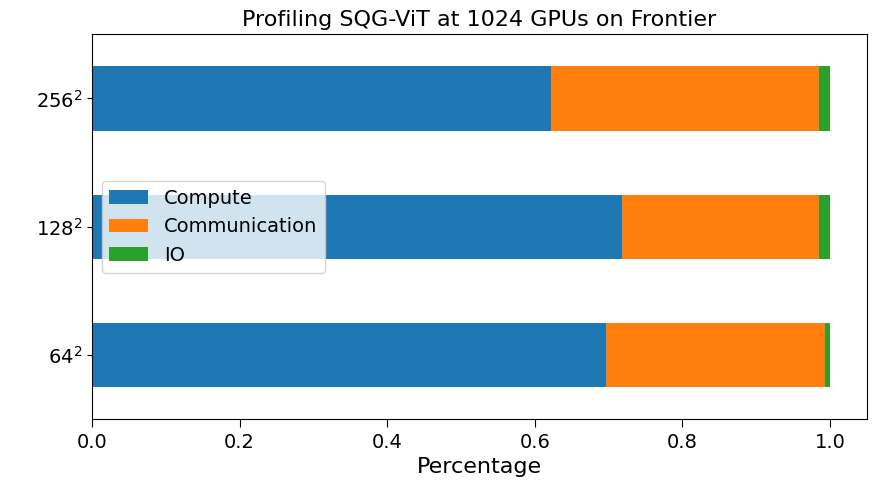

In [32]:
labels = ['$64^2$','$128^2$', '$256^2$']

comp = [perc_64[0], perc_128[0], perc_256[0]]
comm = [perc_64[1], perc_128[1], perc_256[1]]
io = [perc_64[2], perc_128[2], perc_256[2]]

data = {"Compute": comp, "Communication": comm, "IO": io }

print(data)

df = pd.DataFrame(data, index=labels)
#df = pd.DataFrame(data, columns=['A', 'B'], index = labels) #, 'ARC-E'
                                                       #,'HT-CC', 'HT-CP', 'HT-CM', 'HT-CCS'])

print(df)

ax = df.plot(kind='barh', figsize=(10,5), stacked=True )
#ax.set_xticks(df.index)
ax.set_yticklabels(df.index, rotation=0)

ax.set_title("Profiling SQG-ViT at 1024 GPUs on Frontier")
ax.set_xlabel('Percentage')
ax.set_ylabel(' ')
ax.legend(loc='center left')
plt.savefig('profile.png', dpi=300, bbox_inches='tight')

In [15]:
import re
def extract_runtime(file_path):
    with open(file_path, 'r') as file:
        content = file.read()

    # Define the regular expression pattern to find the time
    pattern = r'time = (\d+\.\d+)'

    # Search for the pattern in the content of the file
    match = re.search(pattern, content)

    if match:
        # Extract the time value as a floating number
        time_value = float(match.group(1))
        return time_value/10
    else:
        return None
    
print(extract_runtime("data/ensf/10M/n1/log_atan.log"))    

2.887


[0.36535, 0.36376, 0.36313, 0.3649, 0.35325]


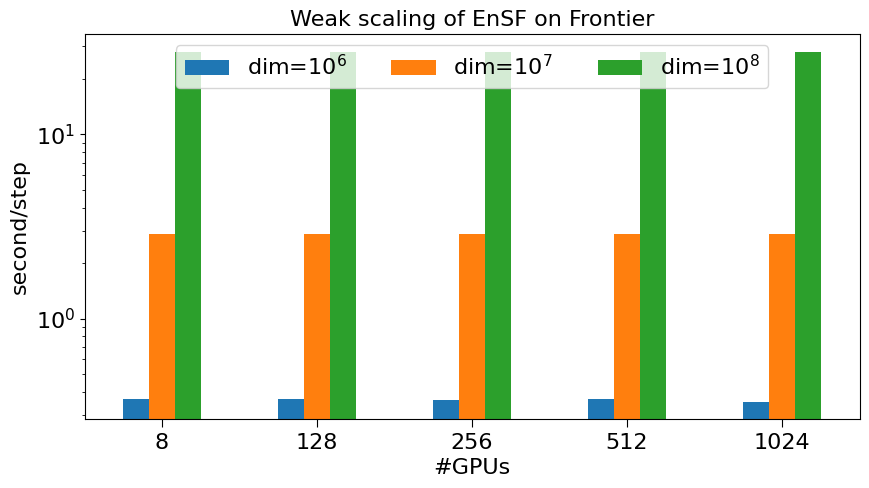

In [36]:
nodes = [1,16,32,64,128]

M1 = [extract_runtime(f"data/ensf/1M/n{n}/log_atan.log") for n in nodes ]
M10 = [extract_runtime(f"data/ensf/10M/n{n}/log_atan.log") for n in nodes ]
M100 = [extract_runtime(f"data/ensf/100M/n{n}/log_atan.log") for n in nodes ]

print(M1)

font = {'family': 'sans-serif',
        'color':  'black',
        'weight': 'normal',
        'size': 18,
        }
data = {"dim=$10^6$": M1,
          "dim=$10^7$": M10,
        "dim=$10^8$": M100,
         }

df = pd.DataFrame(data, index=np.array(nodes)*8)


ax = df.plot(kind='bar', figsize=(10,5))
ax.set_xticklabels(df.index, rotation=0)
ax.set_yscale('log')

ax.tick_params(axis='x', which='major', labelsize=16, colors='k')
ax.tick_params(axis='y', which='major', labelsize=16, colors='k')
#ax.set_yticklabels(df.index, rotation=0)

ax.set_title("Weak scaling of EnSF on Frontier")
ax.set_xlabel("#GPUs")
ax.set_ylabel('second/step')

ax.legend(loc='upper center', fontsize=16, ncol=3)
plt.savefig('ensf.png', dpi=300, bbox_inches='tight')

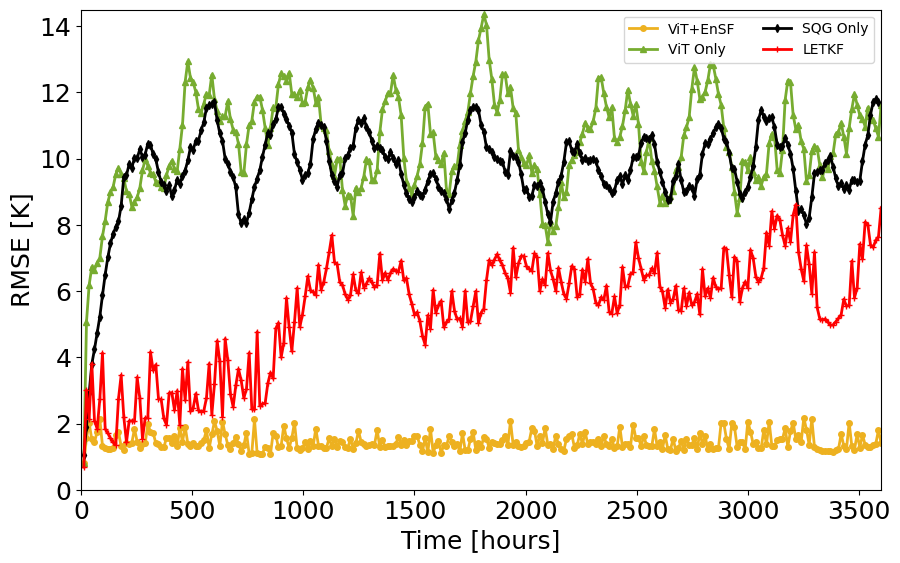

In [7]:
### Fig. 4 - RMSE for the four test cases
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.io import loadmat

# Load data
SQG = pd.read_excel("./coupled_vit_ensf/coupled_results/sqg_only_one_ensmble.xlsx").values.flatten()
Vitonly = pd.read_csv("./coupled_vit_ensf/coupled_results/rmse_ensf_initial_only.csv").values.flatten()
vit_Ensf = pd.read_csv("./coupled_vit_ensf/coupled_results/rmse_ensf_jump_noise.csv").values.flatten()
mat_data = loadmat('./coupled_vit_ensf/coupled_results/Linear_shocks.mat')
LETKF = mat_data['LETKF'].flatten() 

dt = 12
times = np.arange(dt, dt * len(Vitonly) + dt, dt)  # Time array based on longest dataset

# Scale factor
scale_factor = 1

# Plot configuration
plt.figure(figsize=(10, 6))
ax = plt.gca()
plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9)

# Plotting data
ax.plot(times[:len(vit_Ensf)], vit_Ensf / scale_factor, '-o', color='#EDB120', markersize=4, linewidth=2, label='ViT+EnSF')
ax.plot(times[:len(Vitonly)], Vitonly / scale_factor, '-^', color='#77AC30', markersize=4, linewidth=2, label='ViT Only')
ax.plot(times[:len(SQG)], SQG / scale_factor, '-d', color='k', markersize=4, linewidth=2, label='SQG Only')
ax.plot(times[:len(LETKF)], LETKF / scale_factor, '-+', color='red', markersize=4, linewidth=2, label='LETKF') 

# Adding legend, labels, and limits
ax.legend(loc='best', ncol=2)
ax.set_xlabel('Time [hours]', fontsize=18, fontname='DejaVu Sans')
ax.set_ylabel('RMSE [K]', fontsize=18, fontname='DejaVu Sans')
ax.set_ylim([0, 14.5])
ax.set_xlim([0, 3600])

# Font settings for ticks
ax.tick_params(axis='both', labelsize=18)
# plt.savefig('py_plot_SC24_Fig_4.png', dpi=1200)
plt.show()

